# GPU Monitoring
...

## Load Data into Dataframes

In [55]:
%pip install pandas
%pip install matplotlib



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.8.2-cp311-cp311-macosx_10_12_x86_64.whl (7.6 MB)
  Using cached contourpy-1.2.0-cp311-cp311-macosx_10_9_x86_64.whl (258 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.1 MB/s eta 0:00:0000:0100:01
  Using cached kiwisolver-1.4.5-cp311-cp311-macosx_10_9_x86_64.whl (68 kB)
  Using cached pillow-10.2.0-cp311-cp311-macosx_10_10_x86_64.whl (3.5 MB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [93]:
import sqlite3
import pandas as pd

connection = sqlite3.connect("data/gpu_monitor.db")

gpu_infos: pd.DataFrame = pd.read_sql_query("SELECT * FROM 'gpu_infos';", connection)
process_infos: pd.DataFrame = pd.read_sql_query("SELECT * FROM 'process_infos';", connection)

connection.close()

In [19]:
from datetime import datetime
import re

month_pattern = re.compile("[A-Z][a-z]{2}")

def split_process_infos(text: str) -> pd.Series:
    # text contains fields for %mem=,%cpu=,user=,stat=,bsdstart=,bsdtime=,cmd=
    components = text.strip().split()

    memory_percentage = float(components[0])
    cpu_percentage = float(components[1])
    user = components[2]
    status = components[3]
    
    # From the ps man page: If the process was started less than 24 hours ago, the
    # output format is " HH:MM", else it is "Mmm:SS" (where Mmm is the three letters 
    # of the month).
    if month_pattern.match(components[4]):
        created_at = " ".join(components[4:6])

        # From the ps man page: [bsdtime is] accumulated cpu time, user + system.  The
        # display format is usually "MMM:SS"
        cpu_time = components[6]
        
        cmd = " ".join(components[7:])
    else:
        created_at = components[4]

        # From the ps man page: [bsdtime is] accumulated cpu time, user + system.  The
        # display format is usually "MMM:SS"
        cpu_time = components[5]
        
        cmd = " ".join(components[6:])
    
    return pd.Series([cpu_percentage, memory_percentage, user, status, created_at, cpu_time, cmd])

process_infos[["cpu_percentage", "memory_percentage", "user", "status", "created_at", "cpu_time", "cmd"]] = process_infos["pid_info"].apply(split_process_infos)
process_infos = process_infos.drop(columns=["pid_info"])

In [ ]:
# Type conversions

def 


In [20]:
process_infos.head()

,pid,host_id,timestamp,cpu_percentage,memory_percentage,user,created_at,cmd,cpu_time,status
0,4164634,teach2,2024-01-29 13:37:27,1.6,8.9,root,Jan 18,/usr/local/bin/python -m ipykernel_launcher -f...,271:42,Ssl
1,441525,teach2,2024-01-29 13:37:27,13.1,0.8,root,Jan 26,/usr/local/bin/python -m ipykernel_launcher -f...,609:36,Ssl
2,1823085,teach3,2024-01-29 13:37:28,55.5,0.9,joerg,13:00,/usr/bin/python3 -m ipykernel_launcher -f /roo...,20:45,Ssl
3,1823085,teach3,2024-01-29 13:37:28,55.5,0.9,joerg,13:00,/usr/bin/python3 -m ipykernel_launcher -f /roo...,20:45,Ssl
4,4164634,teach2,2024-01-29 13:44:56,1.6,8.9,root,Jan 18,/usr/local/bin/python -m ipykernel_launcher -f...,271:42,Ssl


In [103]:
def remove_non_numbers(gpu_memory: str) -> str:
    # Avoid type error if conversion has already been called
    if type(gpu_memory) == int: 
        return gpu_memory
    
    return gpu_memory.split()[0]

gpu_infos["gpu_memory"] = gpu_infos["gpu_memory"].apply(remove_non_numbers)
gpu_infos["gpu_memory"] = gpu_infos["gpu_memory"].apply(pd.to_numeric)

try:
    gpu_infos["timestamp"] = gpu_infos["timestamp"].apply(lambda x: datetime.fromisoformat(x))
except TypeError:
    pass # Avoid reexecution

gpu_infos.head()

pid                    int64
gpu_memory             int64
host_id               object
timestamp     datetime64[ns]
dtype: object


,pid,gpu_memory,host_id,timestamp
0,4164634,1711,teach2,2024-01-29 13:37:27
1,441525,1887,teach2,2024-01-29 13:37:27
2,1823085,80890,teach3,2024-01-29 13:37:28
3,1823085,30566,teach3,2024-01-29 13:37:28
4,4164634,1711,teach2,2024-01-29 13:44:56


In [ ]:
# TODO: Parse types of timestamp and floats

## Analyse Data
Interesting analysis questions include:
* In which context do gpu intensive programs run?
* How is gpu usage distributed? (visualize over time)
* Which resources do gpu-using processes also use? (memory, cpu)

In [106]:
gpu_info_dict = {}

hosts = gpu_infos["host_id"].unique()
for host in hosts:
    gpu_info_dict[host] = gpu_infos.loc[gpu_infos["host_id"] == host]

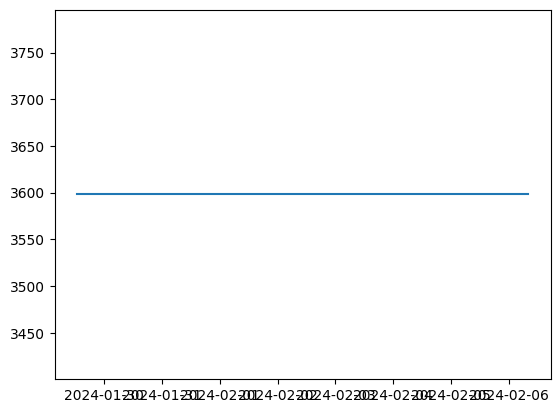

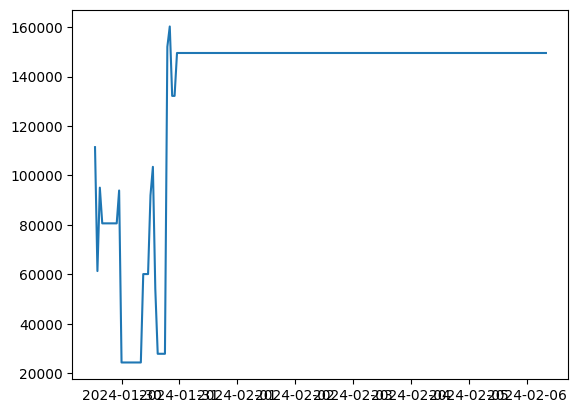

In [148]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

sampling_interval = timedelta(minutes=60)

for host, host_gpu_infos in gpu_info_dict.items():
    gpu_memory_infos = host_gpu_infos[["timestamp", "gpu_memory"]]

    gpu_memory_infos = gpu_memory_infos.groupby("timestamp").sum()

    # Make sure timestamp is available as column name again 
    gpu_memory_infos.reset_index(inplace = True) 
    
    gpu_memory_infos = gpu_memory_infos.set_index("timestamp").resample(sampling_interval).max()

    # Make sure timestamp is available as column name again 
    gpu_memory_infos.reset_index(inplace = True)
    
    # Resampling introduces NaN value depending on the time interval. Remove them for plotting.
    gpu_memory_infos.dropna(subset=["gpu_memory"], inplace=True)
    
    ax = plt.subplot()
    ax.plot(gpu_memory_infos["timestamp"], gpu_memory_infos["gpu_memory"])
    ax.xaxis_date()

    plt.show()

In [110]:
gpu_memory_infos.head()

,timestamp,gpu_memory
2,2024-01-29 13:37:28,80890
3,2024-01-29 13:37:28,30566
6,2024-01-29 13:44:57,80894
9,2024-01-29 13:45:26,81088
12,2024-01-29 13:45:56,81088
